In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate
import numpy as np

In [2]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
CHANNELS=3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 408 files belonging to 7 classes.


In [4]:
class_names = dataset.class_names
class_names

['Banana Black Sigatoka Disease',
 'Banana Bract Mosaic Virus Disease',
 'Banana Healthy Leaf',
 'Banana Insect Pest Disease',
 'Banana Moko Disease',
 'Banana Panama Disease',
 'Banana Yellow Sigatoka Disease']

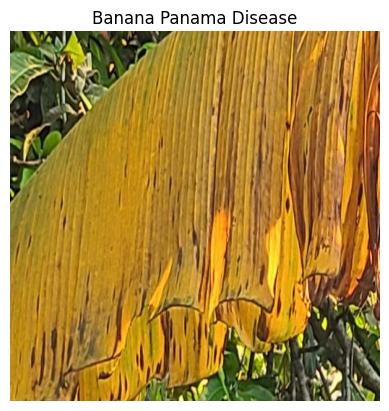

In [5]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[0]])

In [6]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle = True,shuffle_size=100000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    return train_ds,val_ds,test_ds

In [7]:
train_size = 0.8
train_ds = dataset.take(10)
test_ds = dataset.skip(10)
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [8]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/512)])

In [9]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)])

In [11]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [12]:
def GoogLeNet(input_shape):
  # input layer 
  input_layer = Input(shape = input_shape)

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(7, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1000, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [13]:
input_shape = IMAGE_SIZE, IMAGE_SIZE, CHANNELS
model = GoogLeNet(input_shape)
model.build(input_shape=input_shape)

In [173]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_177 (Conv2D)         (None, 253, 253, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_39 (MaxPooli  (None, 126, 126, 64)         0         ['conv2d_177[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_178 (Conv2D)         (None, 126, 126, 64)         4160      ['max_pooling2d_39[0][

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [175]:
model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/50
10/10 [==============================] - 164s 14s/step - loss: 15.5742 - dense_19_loss: 3.7584 - dense_16_loss: 7.4429 - dense_18_loss: 4.3730 - dense_19_accuracy: 0.1410 - dense_16_accuracy: 0.1891 - dense_18_accuracy: 0.1827 - val_loss: 6.0241 - val_dense_19_loss: 2.2909 - val_dense_16_loss: 1.7513 - val_dense_18_loss: 1.9819 - val_dense_19_accuracy: 0.1562 - val_dense_16_accuracy: 0.3438 - val_dense_18_accuracy: 0.1875
Epoch 2/50
10/10 [==============================] - 163s 15s/step - loss: 6.1834 - dense_19_loss: 2.1548 - dense_16_loss: 1.7157 - dense_18_loss: 2.3129 - dense_19_accuracy: 0.2031 - dense_16_accuracy: 0.3313 - dense_18_accuracy: 0.2594 - val_loss: 5.2254 - val_dense_19_loss: 1.9720 - val_dense_16_loss: 1.6726 - val_dense_18_loss: 1.5809 - val_dense_19_accuracy: 0.1562 - val_dense_16_accuracy: 0.2500 - val_dense_18_accuracy: 0.3125
Epoch 3/50
10/10 [==============================] - 153s 15s/step - loss: 5.5134 - dense_19_loss: 1.9251 - dense_16_loss: 1.585

In [193]:
print(model.evaluate(test_ds))

1/1 [==============================] - 3s 3s/step - loss: 0.7947 - dense_19_loss: 0.4895 - dense_16_loss: 0.1087 - dense_18_loss: 0.1966 - dense_19_accuracy: 0.8438 - dense_16_accuracy: 0.9688 - dense_18_accuracy: 0.9062
[0.7947260141372681, 0.4894799292087555, 0.10865285247564316, 0.19659323990345, 0.84375, 0.96875, 0.90625]


Actual name =  Banana Healthy Leaf
1/1 [==============================] - 5s 5s/step
[2, 2, 2]
2
[0.9972941, 0.9992391, 0.9992673]
Predicted class =  Banana Healthy Leaf
Confidence =  99.93


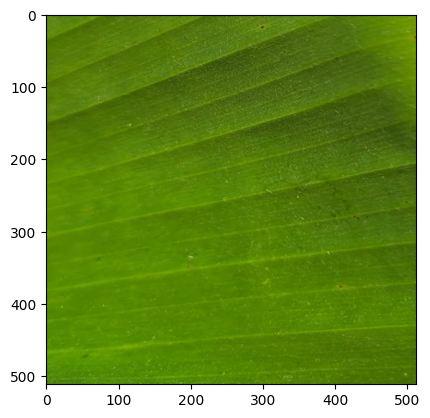

In [16]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    plt.imshow(first_image)
    print("Actual name = ",class_names[first_label])

    prediction = new_model.predict(image_batch)
    val = []
    confi = []
    for i in prediction:
        val.append(np.argmax(i[0]))
        confi.append(np.max(i[0]))
    print(val)
    max = 0
    for i in confi:
        if(i>max):
            max = i
    index = confi.index(max)
    print(index)
    print(confi)
    print("Predicted class = ",class_names[val[index]])
    print("Confidence = ",round(100*max,2))

In [194]:
model_version = "Version_2"
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/Version_2\assets


INFO:tensorflow:Assets written to: ../models/Version_2\assets


In [15]:
new_model = tf.keras.models.load_model(f'models/Version_2')